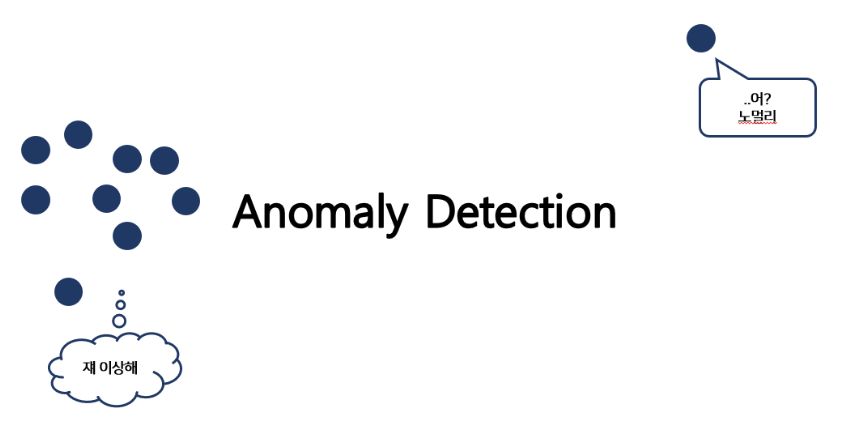

이상치 데이터를 찾는 데이터 분석 기법  
범주 간 불균형이 심하지 않을 때는 Classification 기법 사용  
대부분의 데이터가 한 범주에 속하고 극소수의 데이터만 다른 범주에 속할 때 사용하는 기법  

# Dataset  
  
Thyroid Disease dataset 갑상선 질환 데이터  
data size (3772, 6)  
갑상선 기능 저하증 여부 분류 : 정상(0), 이상(1)  
http://odds.cs.stonybrook.edu/thyroid-disease-dataset/

In [1]:
from scipy import io

mat_file = io.loadmat('./thyroid.mat')

x = mat_file.get('X')
y = mat_file.get('y')

y = y.astype('int')

train_x = x[:3017]
train_y = y[:3017]
test_x = x[3017:]
test_y = y[3017:]

import pandas as pd

xx = pd.DataFrame(train_x)
yy = pd.DataFrame(train_y)
train = pd.concat([xx,yy],axis=1)
train.columns = ['0','1','2','3','4','5','train_y']
train = train.drop(train[train['train_y']==1].index).reset_index(drop=True)
trainx = train.drop(['train_y'], axis=1)
train_x = trainx.values.tolist()

# Gaussian Density-based Anomaly Detection

모든 데이터가 하나의 Gaussian 분포로부터 생성됨을 가정하고 각 데이터가 생성될 확률 추정  
생성 확률이 낮으면 이상치로 판단

In [2]:
from sklearn.covariance import EllipticEnvelope
import numpy as np

g1 = []

def Gaussian(percent) :
    
    clf = EllipticEnvelope()
    clf.fit(train_x)

    # 평가 데이터 중 threshold를 넘는 이상치 구함
    y_pred = clf.decision_function(test_x).ravel()
    threshold = np.percentile(y_pred, percent)
    outliers = y_pred < threshold

    outliers_new = []

    for i in outliers :
        if i==True :
            outliers_new.append(1)
        else :
            outliers_new.append(0)

    from sklearn.metrics import confusion_matrix

    matrix = confusion_matrix(test_y, outliers_new)
    
    g1.append(matrix[1][0]/(matrix[1][0]+matrix[1][1]))

    # 평가 지표 : False Acceptance Rate
    return(matrix[1][0]/(matrix[1][0]+matrix[1][1]))

In [3]:
g2 = []

def Gaussian2(percent) :
    
    clf = EllipticEnvelope()
    clf.fit(train_x)

    y_pred = clf.decision_function(test_x).ravel()
    threshold = np.percentile(y_pred, percent)
    outliers = y_pred < threshold

    outliers_new = []

    for i in outliers :
        if i==True :
            outliers_new.append(1)
        else :
            outliers_new.append(0)

    from sklearn.metrics import confusion_matrix

    matrix = confusion_matrix(test_y, outliers_new)
    
    g2.append(matrix[0][1]/(matrix[0][0]+matrix[0][1]))

    # 평가 지표 : False Rejection Rate
    return(matrix[0][1]/(matrix[0][0]+matrix[0][1]))

In [4]:
for i in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5] :
    print(i, ':', Gaussian(i), ',', Gaussian2(i))

0.1 : 0.9375 , 0.0
0.2 : 0.875 , 0.0
0.3 : 0.8125 , 0.0
0.4 : 0.8125 , 0.0013531799729364006
0.5 : 0.8125 , 0.0013531799729364006
0.6 : 0.75 , 0.0013531799729364006
0.7 : 0.6875 , 0.0013531799729364006
0.8 : 0.625 , 0.0013531799729364006
0.9 : 0.625 , 0.0013531799729364006
1 : 0.5625 , 0.0013531799729364006
2 : 0.375 , 0.008119079837618403
3 : 0.125 , 0.012178619756427604
4 : 0.0 , 0.02029769959404601
5 : 0.0 , 0.029769959404600813


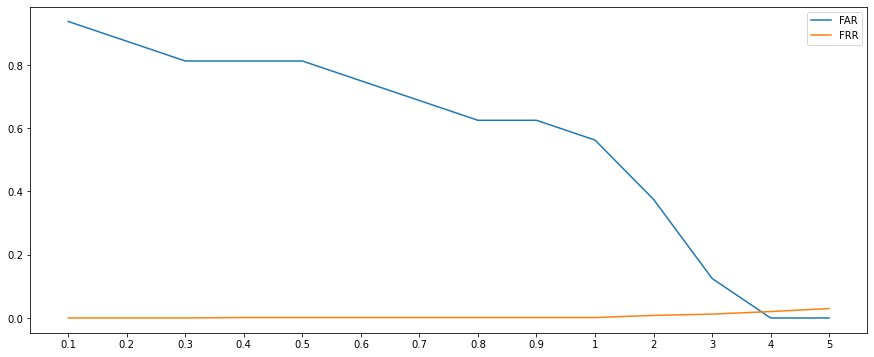

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))
plt.plot(g1, label='FAR')
plt.plot(g2, label='FRR')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13], labels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5])
plt.legend()

Gaussian 방법론은 데이터에 대한 가정이 단순하기 때문에 성능이 그렇게 좋지 못하고, 성능 비교시 기준이 되는 용도로 사용된다고 배웠다.  
하지만 실험 결과 해당 데이터에서는 FAR을 기준으로 했을 때 이상치 threshold가 높아질수록 성능이 급격히 좋아짐을 알 수 있었다.  
혹시나 이상치 범위를 너무 넓게 잡아서 성능이 좋아진 것인지, 그래서 정상을 이상으로 잘못 판별하는 경우가 늘어난 것은 아닌지 FRR을 확인해본 결과 FRR은 크게 증가하지 않음을 알 수 있었다.

# Local Outlier Factor

주변부 데이터의 밀도를 고려해 이상 점수 산정  
나는 친구라고 생각하는데, 친구도 나를 친구라고 생각하는지

In [6]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix

def LOF(neighbors) :
    clf = LocalOutlierFactor(n_neighbors=neighbors, novelty=True)
    clf.fit(train_x)
    pred_original = clf.predict(test_x)

    pred = []

    for i in pred_original :
        if i==1 :
            pred.append(0)
        else :
            pred.append(1)

    matrix = confusion_matrix(test_y, pred)
    # 평가 지표 : False Acceptance Rate, False Rejection Rate
    return(matrix[1][0]/(matrix[1][0]+matrix[1][1]), matrix[0][1]/(matrix[0][0]+matrix[0][1]))

In [7]:
for i in [1,3,5,7,9,11,13,15,20,30] :
    print(i, ':', LOF(i))

1 : (0.125, 0.18403247631935046)
3 : (0.125, 0.06901217861975643)
5 : (0.125, 0.07036535859269283)
7 : (0.125, 0.06224627875507442)
9 : (0.125, 0.058186738836265225)
11 : (0.0, 0.06765899864682003)
13 : (0.0, 0.06495263870094722)
15 : (0.0, 0.06765899864682003)
20 : (0.0, 0.06359945872801083)
30 : (0.0, 0.06765899864682003)


LOF 방법론에서 n_neighbors에 따라 성과가 크게 변화할 것이라고 예상했던 것과 반대로  
n_neighbors는 성능에 별다른 영향을 미치지 않았다.  
실험 데이터가 고르게 분포하고 있다고 해석해본다.

In [8]:
l1 = []
l2 = []

def LOF2(con) :
    clf = LocalOutlierFactor(novelty=True, contamination=con)
    clf.fit(train_x)
    pred_original = clf.predict(test_x)

    pred = []

    for i in pred_original :
        if i==1 :
            pred.append(0)
        else :
            pred.append(1)

    matrix = confusion_matrix(test_y, pred)
    
    l1.append(matrix[1][0]/(matrix[1][0]+matrix[1][1]))
    l2.append(matrix[0][1]/(matrix[0][0]+matrix[0][1]))
    
    # 평가 지표 : False Acceptance Rate, False Rejection Rate
    return(matrix[1][0]/(matrix[1][0]+matrix[1][1]), matrix[0][1]/(matrix[0][0]+matrix[0][1]))

In [9]:
for i in [0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01,0.02,0.03,0.04,0.05] :
    print(i, ':', LOF2(i))

0.001 : (0.75, 0.0)
0.002 : (0.6875, 0.0013531799729364006)
0.003 : (0.6875, 0.0027063599458728013)
0.004 : (0.6875, 0.0040595399188092015)
0.005 : (0.5625, 0.0040595399188092015)
0.006 : (0.375, 0.0040595399188092015)
0.007 : (0.375, 0.0040595399188092015)
0.008 : (0.375, 0.005412719891745603)
0.009 : (0.375, 0.005412719891745603)
0.01 : (0.3125, 0.006765899864682003)
0.02 : (0.25, 0.02571041948579161)
0.03 : (0.0, 0.04194857916102842)
0.04 : (0.0, 0.056833558863328824)
0.05 : (0.0, 0.07036535859269283)


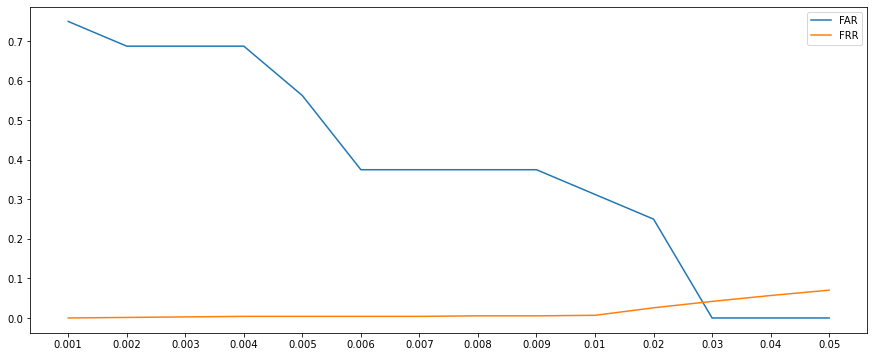

In [10]:
plt.figure(figsize=(15,6))
plt.plot(l1, label='FAR')
plt.plot(l2, label='FRR')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13], labels=[0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01,0.02,0.03,0.04,0.05])
plt.legend()

Gaussian 방법론 에서 FAR이 0.5625가 되기 위해서는 이상치가 전체의 1%를 차지한다고 가정해야 하지만,  
LOF 방법론 에서는 FAR이 0.5%만 차지한다고 가정해도 된다.  
FAR 관점에서 LOF 방법론은 Gaussian 방법론보다 더 작은 threshold로 더 좋은 성과를 보인다.  
하지만 그만큼 FRR이 더 크게 측정되기 때문에 threshold 결정에 주의가 필요하다.(하지만 값이 그렇게 큰 편은 아니다.)

# One-Class Support Vector Machine

정상 범주를 명확하게 지정하고 해당 범주에서 특정 거리 이상 떨어지면 이상치로 판단  
Gaussian(RBF) kernel 사용

In [11]:
from sklearn.svm import OneClassSVM

o1 = []
o2 = []

def OCSVM(gg) :
    clf = OneClassSVM(kernel='rbf', gamma=gg, nu=0.05)
    clf.fit(train_x)
    pred_original = clf.predict(test_x)

    pred = []

    for i in pred_original :
        if i==1 :
            pred.append(0)
        else :
            pred.append(1)

    matrix = confusion_matrix(test_y, pred)
    
    o1.append(matrix[1][0]/(matrix[1][0]+matrix[1][1]))
    o2.append(matrix[0][1]/(matrix[0][0]+matrix[0][1]))
    
    # 평가 지표 : False Acceptance Rate, False Rejection Rate
    return(matrix[1][0]/(matrix[1][0]+matrix[1][1]), matrix[0][1]/(matrix[0][0]+matrix[0][1]))

In [12]:
for i in [0.0001,0.001,0.1,1,5,10,50,100] :
    print(i, ':', OCSVM(i))

0.0001 : (0.375, 0.04194857916102842)
0.001 : (0.3125, 0.044654939106901215)
0.1 : (0.3125, 0.04736129905277402)
1 : (0.3125, 0.04330175913396482)
5 : (0.0625, 0.04871447902571042)
10 : (0.0, 0.04871447902571042)
50 : (0.0, 0.09607577807848444)
100 : (0.0, 0.16238159675236807)


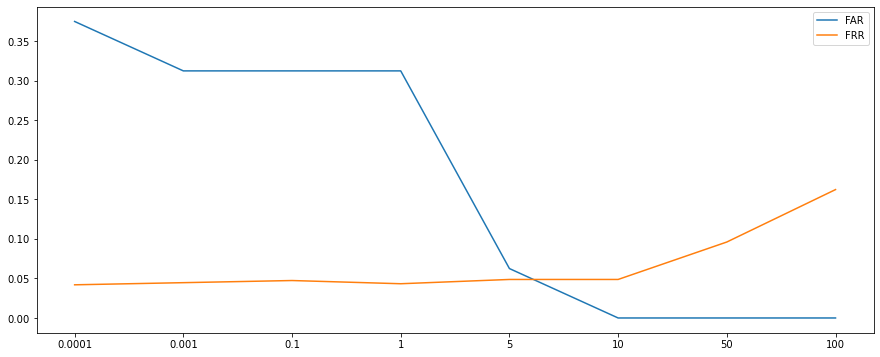

In [13]:
plt.figure(figsize=(15,6))
plt.plot(o1, label='FAR')
plt.plot(o2, label='FRR')
plt.xticks([0,1,2,3,4,5,6,7], labels=[0.0001,0.001,0.1,1,5,10,50,100])
plt.legend()

OCSVM 방법론에서는 gamma가 커질수록 FAR 성능이 좋아지고, FRR 성능이 나빠진다.  
하지만 FAR 성능 개선 정도가 FRR 성능 하락 정도보다 더 크기 때문에 gamma 값을 크게 하는 것이 좋을 것 같다.(10 이상)

In [14]:
oo1 = []
oo2 = []

def OCSVM2(nn) :
    clf = OneClassSVM(kernel='rbf', gamma=10, nu=nn)
    clf.fit(train_x)
    pred_original = clf.predict(test_x)

    pred = []

    for i in pred_original :
        if i==1 :
            pred.append(0)
        else :
            pred.append(1)

    matrix = confusion_matrix(test_y, pred)
    
    oo1.append(matrix[1][0]/(matrix[1][0]+matrix[1][1]))
    oo2.append(matrix[0][1]/(matrix[0][0]+matrix[0][1]))
    
    # 평가 지표 : False Acceptance Rate, False Rejection Rate
    return(matrix[1][0]/(matrix[1][0]+matrix[1][1]), matrix[0][1]/(matrix[0][0]+matrix[0][1]))

In [15]:
for i in [0.001,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1] :
    print(i, ':', OCSVM2(i))

0.001 : (0.25, 0.016238159675236806)
0.01 : (0.25, 0.016238159675236806)
0.02 : (0.1875, 0.018944519621109608)
0.03 : (0.0625, 0.03247631935047361)
0.04 : (0.0, 0.04330175913396482)
0.05 : (0.0, 0.04871447902571042)
0.06 : (0.0, 0.058186738836265225)
0.07 : (0.0, 0.06495263870094722)
0.08 : (0.0, 0.08254397834912043)
0.09 : (0.0, 0.09878213802435724)
0.1 : (0.0, 0.11772665764546685)


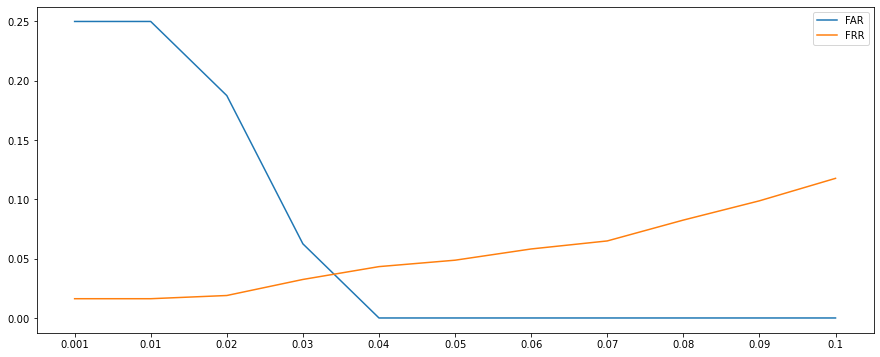

In [16]:
plt.figure(figsize=(15,6))
plt.plot(oo1, label='FAR')
plt.plot(oo2, label='FRR')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10], labels=[0.001,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1])
plt.legend()

OCSVM 방법론에서 gamma가 10일 때, nu는 값이 커질수록 FAR 성능이 좋고, FRR 성능이 나쁘게 나온다.  
마찬가지로 FAR 성능 개선 속도가 FRR 성능 하락 속도보다 빠르기 때문에 nu를 크게 하는 것이 좋을 것 같다.(0.04 이상)

종합해보면, gamma가 10이고 nu가 0.04일 때 가장 성능이 좋다고 볼 수 있다.

# Isolation Forests

이상치를 고립시키는 tree 생성  
이상치는 정상 데이터에 비해 상대적으로 적은 분기만으로 고립시킬 수 있음  
분기에 대한 정보로 이상 점수 산정

In [17]:
from sklearn.ensemble import IsolationForest

i1 = []
i2 = []

def IF(threshold) :
    clf = IsolationForest(n_estimators=50, max_samples=5, contamination=float(threshold), random_state=2022)
    clf.fit(train_x)
    pred_original = clf.predict(test_x)
    
    pred = []

    for i in pred_original :
        if i==1 :
            pred.append(0)
        else :
            pred.append(1)

    matrix = confusion_matrix(test_y, pred)
    
    i1.append(matrix[1][0]/(matrix[1][0]+matrix[1][1]))
    i2.append(matrix[0][1]/(matrix[0][0]+matrix[0][1]))
    
    # 평가 지표 : False Acceptance Rate, False Rejection Rate
    return(matrix[1][0]/(matrix[1][0]+matrix[1][1]), matrix[0][1]/(matrix[0][0]+matrix[0][1]))

In [18]:
for i in [0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01,0.02,0.03,0.04,0.05] :
    print(i, ':', IF(i))

0.001 : (0.8125, 0.0013531799729364006)
0.002 : (0.375, 0.009472259810554804)
0.003 : (0.375, 0.009472259810554804)
0.004 : (0.1875, 0.009472259810554804)
0.005 : (0.1875, 0.009472259810554804)
0.006 : (0.1875, 0.010825439783491205)
0.007 : (0.1875, 0.010825439783491205)
0.008 : (0.125, 0.012178619756427604)
0.009 : (0.125, 0.012178619756427604)
0.01 : (0.125, 0.012178619756427604)
0.02 : (0.0625, 0.02706359945872801)
0.03 : (0.0625, 0.04330175913396482)
0.04 : (0.0, 0.058186738836265225)
0.05 : (0.0, 0.06630581867388363)


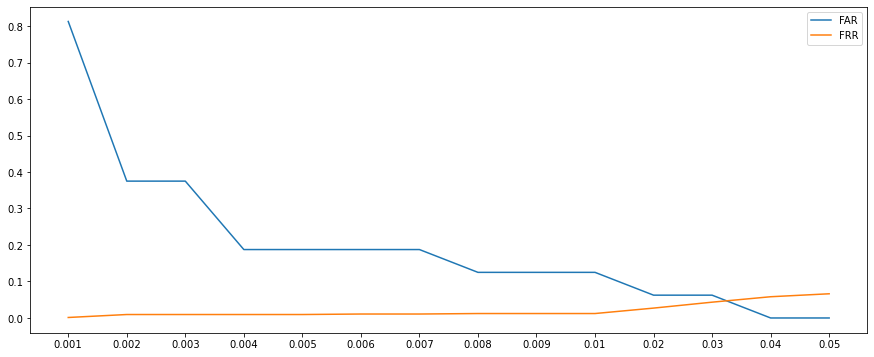

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))
plt.plot(i1, label='FAR')
plt.plot(i2, label='FRR')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13], labels=[0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01,0.02,0.03,0.04,0.05])
plt.legend()

IF 방법론에서도 역시 이상치 비율이 늘어날수록 FAR 성능이 좋아지고, FRR 성능이 나빠진다.  
IF 방법론은 Gaussian, LOF 방법론과 비교해서 이상치 비율에 대한 가정을 가장 작게 할 수 있다.  
FAR이 0.375일 때 세 방법론의 FRR을 비교해보면, Gaussian은 0.008, LOF는 0.004, IF는 0.009로 LOF가 가장 좋은 성능을 보임을 알 수 있다.

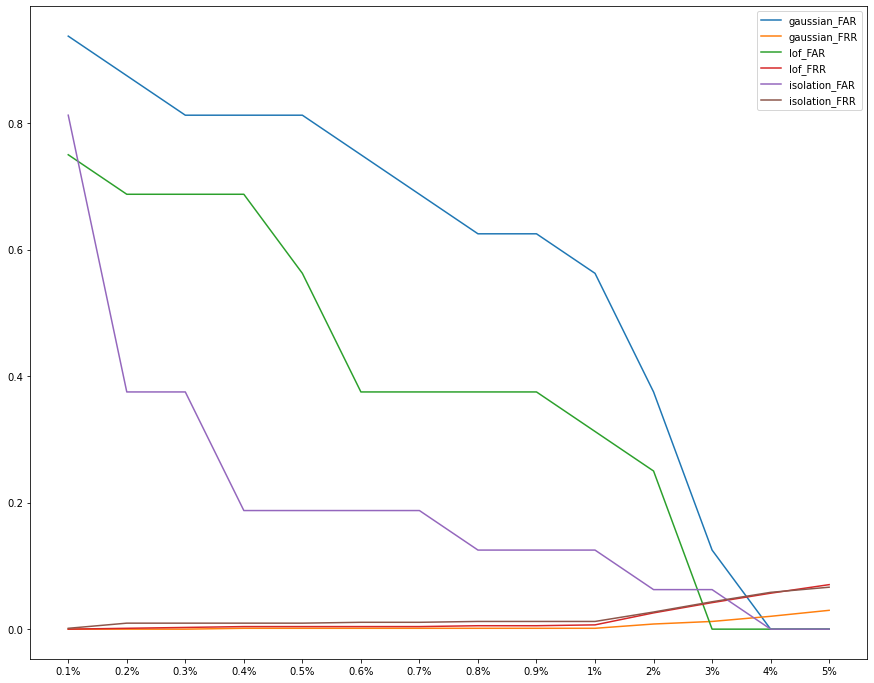

In [22]:
plt.figure(figsize=(15,12))
plt.plot(g1, label='gaussian_FAR')
plt.plot(g2, label='gaussian_FRR')
plt.plot(l1, label='lof_FAR')
plt.plot(l2, label='lof_FRR')
plt.plot(i1, label='isolation_FAR')
plt.plot(i2, label='isolation_FRR')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13], labels=['0.1%','0.2%','0.3%','0.4%','0.5%','0.6%','0.7%','0.8%','0.9%','1%','2%','3%','4%','5%'])
plt.legend()

# DBSCAN

밀도 차이를 기반으로 군집화하는 기법

In [114]:
from sklearn.cluster import DBSCAN

d1 = []
d2 = []

def DB(ee) :
    clf = DBSCAN(eps=ee, min_samples=3)
    pred_original = clf.fit_predict(test_x)

    pred = []

    for i in pred_original :
        if i == -1 :
            pred.append(1)
        else :
            pred.append(i)

    matrix = confusion_matrix(test_y, pred)
    
    d1.append(matrix[1][0]/(matrix[1][0]+matrix[1][1]))
    d2.append(matrix[0][1]/(matrix[0][0]+matrix[0][1]))

    # 평가 지표 : False Acceptance Rate, False Rejection Rate
    return(matrix[1][0]/(matrix[1][0]+matrix[1][1]), matrix[0][1]/(matrix[0][0]+matrix[0][1]))

In [115]:
for i in [0.2,0.25,0.3,0.35,0.4,0.45,0.5] :
    print(i, ':', DB(i))

0.2 : (0.9375, 0.0040595399188092015)
0.25 : (0.9375, 0.0027063599458728013)
0.3 : (0.9375, 0.0013531799729364006)
0.35 : (1.0, 0.0013531799729364006)
0.4 : (1.0, 0.0013531799729364006)
0.45 : (1.0, 0.0013531799729364006)
0.5 : (1.0, 0.0)


데이터가 많지 않아서 min_samples를 3으로 고정하고,  
FAR과 FRR을 간단히 구하기 위해 eps를 두 범주로 나뉘는 0.2~0.5로 변화시키며 실험해보았다.  
그 결과 FAR 성능이 매우 좋지 않았다.